# Part I: Preprocessing

In this tutorial we will demonstrate how `cellarium-ml` can be used to compute mean and variance, identify highly variable genes, and perform dimensionality reduction with PCA.

## Setup

In [1]:
import os

import lightning.pytorch as pl
import numpy as np
import pandas as pd
import scanpy as sc

from cellarium.ml import CellariumAnnDataDataModule, CellariumModule
from cellarium.ml.data import read_h5ad_file
from cellarium.ml.models import IncrementalPCA, OnePassMeanVarStd
from cellarium.ml.preprocessing import get_highly_variable_genes
from cellarium.ml.transforms import Filter, Log1p, NormalizeTotal, ZScore
from cellarium.ml.utilities.core import resolve_ckpt_dir
from cellarium.ml.utilities.data import AnnDataField, collate_fn, densify

sc.settings.set_figure_params(dpi=80, facecolor="white")

## Download dataset

As an example dataset we will use [*A (Balanced) Bone Marrow Reference Map of Hematopoietic Development*](https://cellxgene.cziscience.com/collections/f6c50495-3361-40ed-a819-fb9644396ed9) freely availabe from CELLxGENE.

In [2]:
adata = read_h5ad_file("https://datasets.cellxgene.cziscience.com/8674c375-ae3a-433c-97de-3c56cf8f7304.h5ad")

## Compute the mean and variance

We will calculate the per-gene mean and variance of the normalized and log1p transformed counts. The computation is performed in one-pass by iterating over mini-batches (of size 10,000 cells) and using the [shifted data algorithm](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Computing_shifted_data) to compute the mean and variance. We will use `pl.Trainer` to orchestrate the training which under the hood does the following (pseudocode):

```py
# instantiate the module
onepass_module = CellariumModule(transforms=..., model=...)
# configure_model creates a CellariumPipeline consisting of the transforms and the model
onepass_module.configure_model()

# instantiate the datamodule
datamodule = CellariumAnnDataDataModule(dadc=..., batch_keys=..., batch_size=..., ...)
# setup the iterable dataset
datamodule.setup(stage="fit")

# training loop
# batch dictionary has the same keys as the batch_keys above
for batch_idx, batch in enumerate(datamodule.train_dataloader()):
    # batch is passed through the transforms and the model in the pipeline
    onepass_module.pipeline(batch)
```

Let's instantiate the `CellariumModule` consisting of transforms (`NormalizeTotal` and `Log1p`) and the model (`OnePassMeanVarStd`):

In [3]:
onepass_module = CellariumModule(
    transforms=[
        NormalizeTotal(target_count=10_000),
        Log1p(),
    ],
    model=OnePassMeanVarStd(var_names_g=adata.var_names, algorithm="shifted_data"),
)

Once configured by the `pl.Trainer`, `onepass_module.pipeline` will be a `CellariumPipeline` consisting of a list of `NormalizeTotal`, `Log1p`, `OnePassMeanVarStd` sub-modules. Note, that `CellariumPipeline` is a sub-class of `nn.ModuleList` and its sub-modules can be accessed via slicing. Its forward method accepts a batch dictionary from the dataloader as an input and then runs its sub-modules sequentially by giving them correct arguments from the batch dictionary. The pseudocode looks like this:

```py
# CellariumPipeline forward method
def forward(self, batch: dict) -> dict:
    # the first sub-module is NormalizeTotal
    out = self[0](x_ng=batch["x_ng"], total_mrna_umis_n=batch["total_mrna_umis_n"])
    # overwrite `x_ng` key in the batch with the normalized counts
    batch.update(out)

    # the second sub-module is Log1p
    out = self[1](x_ng=batch["x_ng"])
    # overwrite `x_ng` key in the batch with the log1p transformed counts
    batch.update(out)

    # the third sub-module is OnePassMeanVarStd which processes x_ng and updates its internal state
    out = self[2](x_ng=batch["x_ng"], var_names_g=batch["var_names_g"])
    # this is a no-op because OnePassMeanVarStd returns an empty dictionary
    batch.update(out)

    return batch
```

Next, we will create `CellariumAnnDataDataModule` which is used by the trainer to create the dataloader during training. The `dadc` argument specifies the `AnnData` object to iterate over. However, note that when working with multiple anndata files `DistributedAnnDataCollection` object can also be used. Next, the `batch_keys` dictionary specifies the content of the generated batches. Its keys must match the names of the arguments of the transforms and the model as we have seen above. Namely, in this case it should contain `x_ng`, `total_mrna_umis_n`, and `var_names_g` keys. Its values are `AnnDataField` objects that the datamodule uses to retrieve batch arguments from the anndata object. For example, `x_ng` is obtained by accesing the `raw.X` attribute of an anndata object and then densifying it by using the `cellarium.ml.utilities.data.densify` function. Next, the `batch_size` can be set to a high number since `OnePassMeanVarStd` model is very fast and is not memory intensive. Finally, the `num_workers` should also be set to a high number to ensure that the dataloader doesn't become a bottleneck during training.

In [4]:
datamodule = CellariumAnnDataDataModule(
    dadc=adata,
    batch_keys={
        "x_ng": AnnDataField(attr="raw.X", convert_fn=densify),
        "var_names_g": AnnDataField(attr="var_names"),
        "total_mrna_umis_n": AnnDataField(attr="obs", key="nCount_RNA"),
    },
    batch_size=10_000,
    num_workers=8,
)

Next, initialize `pl.Trainer` by specifying it to use 1 `gpu` accelerator, iterate over entire dataset once, and the directory where to save the checkpoint. Lastly, run the computation by invoking the `fit` method of the trainer.

In [5]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=1,
    default_root_dir="runs/onepass",
)
trainer.fit(onepass_module, datamodule)

/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/yordabay/anaconda3/envs/cellarium/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/mnt/disks/dev/repos/cellarium-ml/cellarium/ml/utilities/distributed.py:52: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:105: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). S

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


### Visualize results

Convert the computed statistics into a dataframe and make a scatter-plot of the mean vs. variance.

In [6]:
onepass_df = pd.DataFrame(
    data={
        "mean": onepass_module.model.mean_g.numpy(),
        "variance": onepass_module.model.var_g.numpy(),
        "n_samples": onepass_module.model.x_size.numpy(),
    },
    index=onepass_module.model.var_names_g,
)
onepass_df.head()

,mean,variance,n_samples
ENSG00000177757,0.000474,0.000702,263159.0
ENSG00000225880,0.018753,0.027754,263159.0
ENSG00000187634,0.001644,0.002092,263159.0
ENSG00000188976,0.267763,0.335251,263159.0
ENSG00000187961,0.005226,0.008233,263159.0


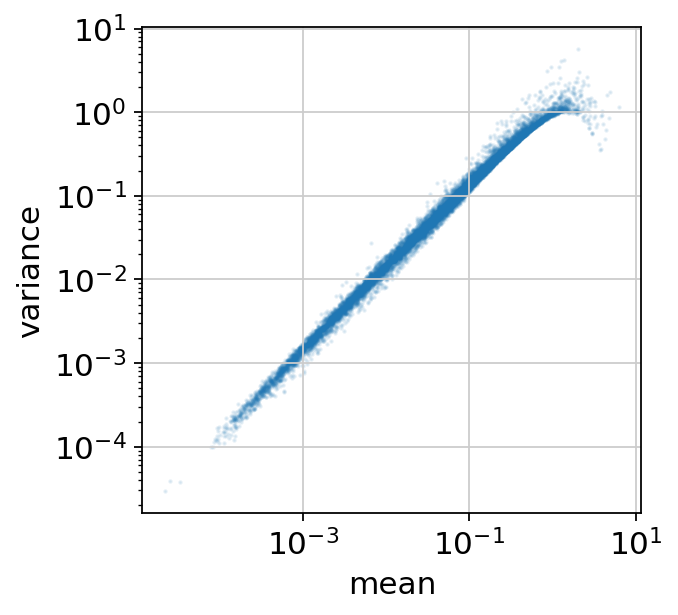

In [7]:
onepass_df.plot(x="mean", y="variance", kind="scatter", s=1, alpha=0.1, logx=True, logy=True, figsize=(4, 4));

### How to load the saved checkpoint?

Let's quickly show how to find the saved checkpoint file by using the `resolve_ckpt_dir` helper function.

In [9]:
onepass_ckpt_dir = resolve_ckpt_dir(trainer)
print("Checkpoints directory: ", onepass_ckpt_dir)
print("List of saved checkpoints: ", os.listdir(onepass_ckpt_dir))

Checkpoints directory:  runs/onepass/lightning_logs/version_0/checkpoints
List of saved checkpoints:  ['epoch=0-step=27.ckpt']


In order to load the checkpoint use `load_from_checkpoint` method:

In [10]:
onepass_ckpt_path = os.path.join(onepass_ckpt_dir, "epoch=0-step=27.ckpt")
loaded_onepass_module = CellariumModule.load_from_checkpoint(onepass_ckpt_path)

## Identify highly-variable genes

`get_highly_variable_genes` from `cellarium.ml` implements the `seurat` flavor of highly-variable gene selection.

In [11]:
hvg_df = get_highly_variable_genes(
    gene_names=onepass_module.model.var_names_g,
    mean=onepass_module.model.mean_g,
    var=onepass_module.model.var_g,
    min_disp=0.5,
    min_mean=0.0125,
    max_mean=3,
)

In [12]:
adata.uns["hvg"] = {"flavor": "seurat"}
adata.var = pd.concat([adata.var, hvg_df], axis=1)

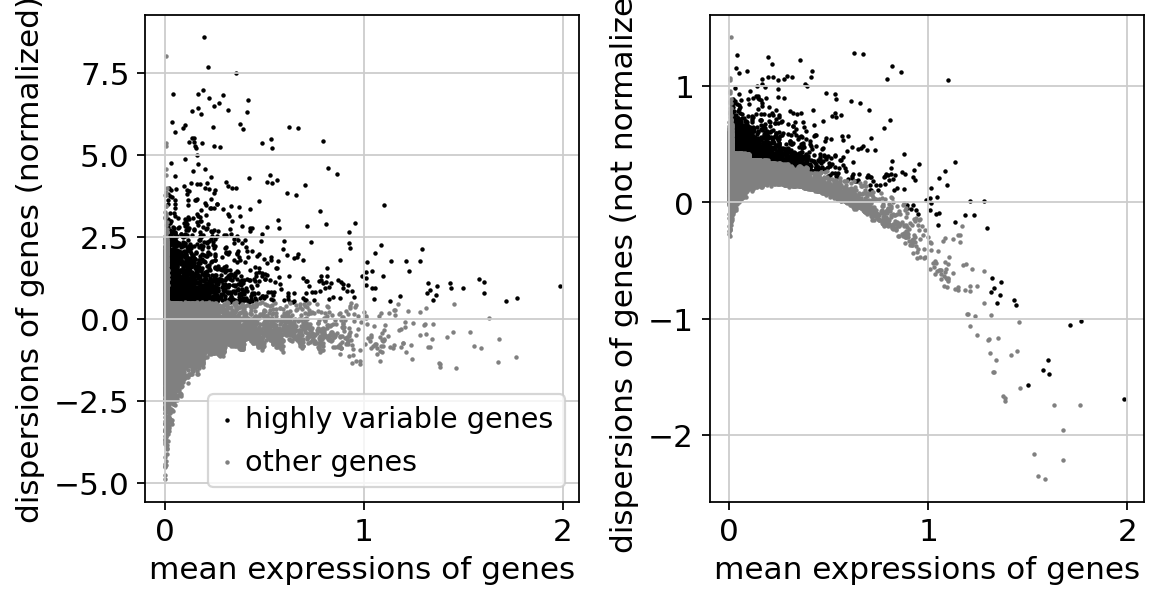

In [13]:
sc.pl.highly_variable_genes(adata)

## Principal component analysis

We will reduce the dimensionality of the data by running incremental PCA to reveal the main axis of variation. Before applying PCA, we will select highly-variable genes and scale the normalized and log1p transformed data to unit variance. Note, that it is more efficient to filter the genes on the CPU by the dataloader workers before the count matrix is moved to the GPU.

In [14]:
pca_module = CellariumModule(
    transforms=[
        Filter(filter_list=adata.var_names[adata.var["highly_variable"]]),
        NormalizeTotal(target_count=10_000),
        Log1p(),
        ZScore(
            mean_g=onepass_module.model.mean_g[adata.var["highly_variable"]],
            std_g=onepass_module.model.std_g[adata.var["highly_variable"]],
            var_names_g=onepass_module.model.var_names_g[adata.var["highly_variable"]],
        ),
    ],
    model=IncrementalPCA(
        var_names_g=adata.var_names[adata.var["highly_variable"]],
        n_components=256,
        perform_mean_correction=True,
    ),
)

/tmp/ipykernel_1704862/1805180937.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_g=onepass_module.model.mean_g[adata.var["highly_variable"]],
/tmp/ipykernel_1704862/1805180937.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_g=onepass_module.model.std_g[adata.var["highly_variable"]],


First, we will fit the PCA model to the data.

In [15]:
datamodule = CellariumAnnDataDataModule(
    dadc=adata,
    batch_keys={
        "x_ng": AnnDataField(attr="raw.X", convert_fn=densify),
        "var_names_g": AnnDataField(attr="var_names"),
        "total_mrna_umis_n": AnnDataField(attr="obs", key="nCount_RNA"),
    },
    batch_size=10_000,
    num_workers=8,
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=1,
    default_root_dir="runs/pca",
)
trainer.fit(pca_module, datamodule)

/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/yordabay/anaconda3/envs/cellarium/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/mnt/disks/dev/repos/cellarium-ml/cellarium/ml/utilities/distributed.py:52: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:105: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/yordabay/anaconda3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). S

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Now, we will use the trained PCA model to embed our data into latent space. In order to ensure that the order of predicted cells (`obs_names_n` key) is preserved we create a new datamodule with `iteration_strategy="same_order"` and `shuffle=False`.

In [16]:
datamodule = CellariumAnnDataDataModule(
    dadc=adata,
    batch_keys={
        "x_ng": AnnDataField(attr="raw.X", convert_fn=densify),
        "var_names_g": AnnDataField(attr="var_names"),
        "total_mrna_umis_n": AnnDataField(attr="obs", key="nCount_RNA"),
        "obs_names_n": AnnDataField(attr="obs_names"),
    },
    batch_size=10_000,
    iteration_strategy="same_order",
    shuffle=False,
    num_workers=8,
)

trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1)
predictions = trainer.predict(pca_module, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

`trainer.predict` returns a list of predictions for each mini-batch. We will use `collate_fn` to concatenate the elements of the list. Embedded data is stored in the value of the `x_ng` key. Cell names are stored under the `obs_names_n` key.

In [17]:
collated_predictions = collate_fn(predictions)
collated_predictions.keys()

dict_keys(['x_ng', 'var_names_g', 'total_mrna_umis_n', 'obs_names_n'])

Save the principal component analysis output into an anndata object so that we can leverage `scanpy`'s plotting tools.

In [18]:
# verify that the order of cells is preserved
assert np.array_equal(adata.obs_names, collated_predictions["obs_names_n"])
# store the PCA embeddings in the obsm attribute
adata.obsm["X_pca"] = collated_predictions["x_ng"].numpy()
# store the PCA components in the varm attribute
adata.varm["PCs"] = np.zeros((adata.n_vars, pca_module.model.n_components))
adata.varm["PCs"][adata.var["highly_variable"]] = pca_module.model.components_kg.T.numpy()
# store the PCA variance explained in the uns attribute
adata.uns["pca"] = {
    "variance": pca_module.model.explained_variance_k.numpy(),
    "variance_ratio": pca_module.model.explained_variance_k.numpy() / onepass_module.model.var_g.sum().numpy(),
}

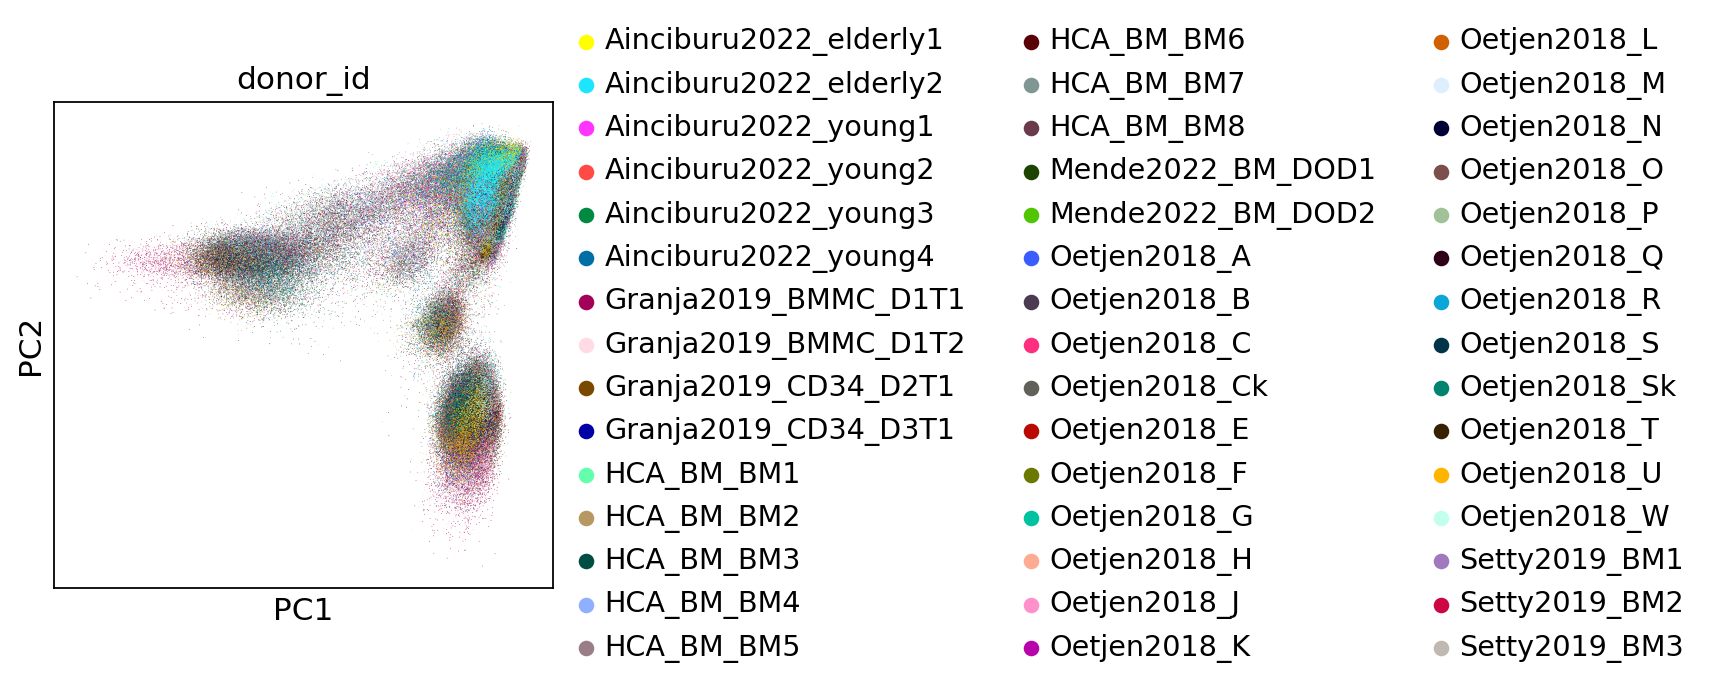

In [19]:
sc.pl.pca(adata, color="donor_id")

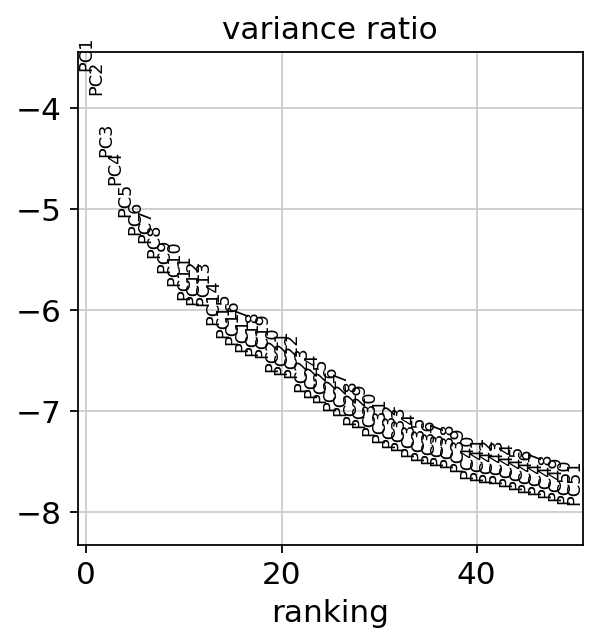

In [20]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)